In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import networkx as nx
import gseapy as gp

## Parse IID network, keep only experimentally confirmed interactions with both genes expressed in brain

- Open browser and navigate to http://iid.ophid.utoronto.ca/
- Click on "Download" and download human annotated PPI network.
- Uncompress the network and save it under filename 'human_annotated_PPIs' in this directory.

In [2]:
iid = pd.read_csv('human_annotated_PPIs.txt', sep='\t')

/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_1090/1041972388.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  iid = pd.read_csv('human_annotated_PPIs.txt', sep='\t')


In [3]:
iid_exp = iid[iid.evidence_type.str.contains('exp')]

In [4]:
iid_brain_exp = iid_exp[iid_exp.brain == 2]
iid_brain_exp.reset_index(inplace=True)
iid_brain_exp = iid_brain_exp[['symbol1','symbol2']]

In [5]:
all_nodes = set(iid_brain_exp.symbol1).union(set(iid_brain_exp.symbol2))

In [6]:
iid_brain_exp.to_csv('iid_brain_exp.txt', index=False, sep=' ')

## Read list of differentiall methylated genes, keep only those contained in filtered IID network

In [138]:
all_seeds_l4m = set(pd.read_csv('L4M_promoters.csv', sep=';', index_col=0).index)
all_seeds_re = set(pd.read_csv('RE_promoters.csv', sep=';', index_col=0).index)
all_seeds_scar = set(pd.read_csv('Scar_promoters.csv', sep=';', index_col=0).index)

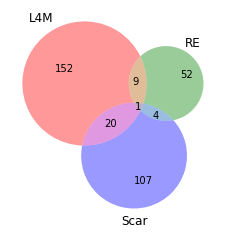

In [139]:
fig, ax = plt.subplots()
venn3([all_seeds_l4m, all_seeds_re, all_seeds_scar], ('L4M', 'RE', 'Scar'), ax=ax)
plt.show()
fig.tight_layout()
fig.savefig('venn.pdf')

In [140]:
seeds_l4m = all_seeds_l4m.intersection(all_nodes)
seeds_re = all_seeds_re.intersection(all_nodes)
seeds_scar = all_seeds_scar.intersection(all_nodes)

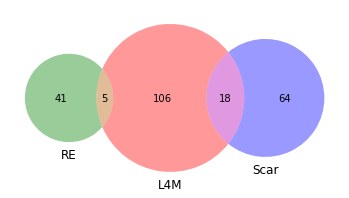

In [141]:
venn3([seeds_l4m, seeds_re, seeds_scar], ('L4M', 'RE', 'Scar'))
plt.show()

In [111]:
def write_seeds(seeds, path):
    with open(path, 'w') as fp:
        fp.write('\n'.join(seeds))

In [112]:
write_seeds(seeds_l4m, 'L4M.txt')

## Run ROBUST-Web

*Workflow to generate the file `L4M_09_corrected.graphml` contained in this repository:*

- Open a browser and navigate to https://robust-web.net.
- Click on "Start app".
- Click on "Upload seeds" and upload the file `L4M.txt`.
- Click on "Upload custom network" and then on "Upload network" to upload the file `iid_brain_exp.txt`.
- Click on "OPTIONAL PARAMETERS" and then set the threshold tau to 0.9.
- Click on "Run ROBUST".
- Click on "Download" to download the computed module and rename the file to 'L4M_09_corrected.graphml'.

*Workflow for in silico validation with DIGEST to generate the plots contained in `digest` subdirectory:*

- In ROBUST-Web's result view, (manually) select all nodes contained in the largest connected component.
- Then click on "DIGEST Enrichment Analysis".
- In DIGEST's result view, click on "Download all files as .zip" (download symbol in top-right corner).

## Extract LCC from ROBUST module

In [2]:
module = nx.read_graphml('L4M_09_corrected.graphml')

In [3]:
largest_cc = max(nx.connected_components(module), key=len)
submodule = module.subgraph(largest_cc).copy()

In [4]:
for node in submodule.nodes():
    submodule.nodes[node].pop('group',None)

In [5]:
for node in submodule.nodes():
    if submodule.nodes[node]['_group'] == 'gene':
        submodule.nodes[node]['isSeed'] = False
    else:
        submodule.nodes[node]['isSeed'] = True
    submodule.nodes[node].pop('_group',None)

In [116]:
nx.write_graphml(submodule, 'LCC_L4M_09_corrected.graphml')

In [122]:
seeds_l4m_submodule = set([node[0] for node in submodule.nodes(data=True) if node[1]['isSeed']])

In [43]:
with open('g_profiler_query.txt', 'w') as fp:
    fp.write(' '.join(list(submodule.nodes)))

## Carry our functional enrichment analysis with g:Profiler

- Open browser and navigate to https://biit.cs.ut.ee/gprofiler/gost
- Run g:GOST with `g_profiler_query.txt` as input query.

## Compute pageranks within LCC of ROBUST module

In [20]:
pagerank_dict = nx.pagerank(submodule)
pageranks = list(pagerank_dict.items())
pageranks.sort(key = lambda t: t[1], reverse=True)

## Plot LCC of ROBUST module

- Node sizes are proportional to PageRank node centralities (larger nodes are more central)
- Node colors show whether genes are differentially methylated (red) or newly found connectors (blue)
- Four top-ranked nodes with highest PageRank centralities are labeled.

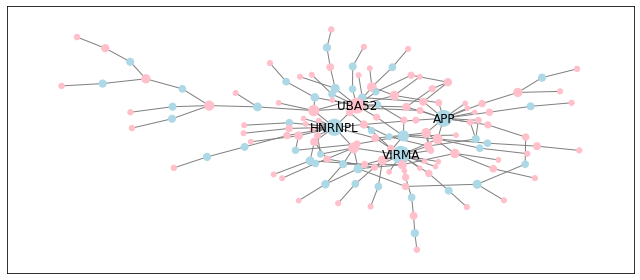

In [36]:
fig, ax = plt.subplots(figsize=(9,4))
top_nodes = [pageranks[i][0] for i in range(4)]
node_labels = {node: node for node in top_nodes}
node_sizes = [pagerank_dict[node] * 7000 for node in submodule.nodes()]
node_colors = []
for node in submodule.nodes(data=True):
    if node[1]['isSeed']:
        node_colors.append('pink')
    else:
        node_colors.append('lightblue')
nx.draw_networkx(submodule,labels=node_labels,ax=ax,node_color=node_colors,edge_color='grey',
                        node_size=node_sizes,pos=nx.kamada_kawai_layout(submodule))
fig.tight_layout()
fig.savefig('L4M_LCC.pdf')

## Find TFs in submodule

In [63]:
all_tfs = set([line.rstrip() for line in open('TF_names_v_1.01.txt')])

In [68]:
ranked_tfs = []
for rank, t in enumerate(pageranks):
    if t[0] in all_tfs:
        ranked_tfs.append((rank, t[0]))

## Plot top-ranked nodes

In [28]:
def plot_star(module, node, ax=None):
    star = nx.ego_graph(module, node)
    node_shapes = []
    node_colors = []
    for node in star.nodes(data=True):
        if node[1]['isSeed']:
            node_shapes.append('o')
            node_colors.append('pink')
        else:
            node_shapes.append('o')
            node_colors.append('lightblue')
    nx.draw_networkx(star, node_color=node_colors, edge_color='grey', ax=ax)

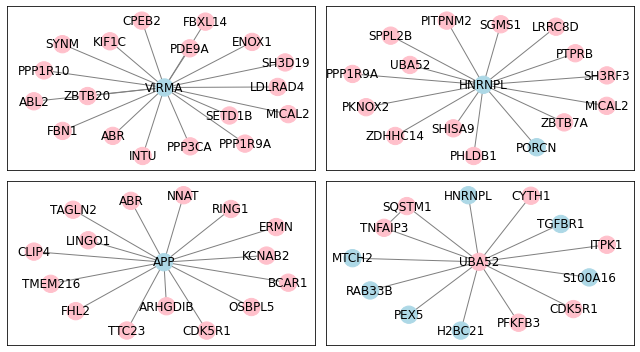

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,5))
plot_star(submodule, top_nodes[0], ax=axes[0,0])
plot_star(submodule, top_nodes[1], ax=axes[0,1])
plot_star(submodule, top_nodes[2], ax=axes[1,0])
plot_star(submodule, top_nodes[3], ax=axes[1,1])
fig.tight_layout()
fig.savefig('L4M_stars_top_4.pdf')

## Plot LCC of ROBUST module together with top-ranked nodes

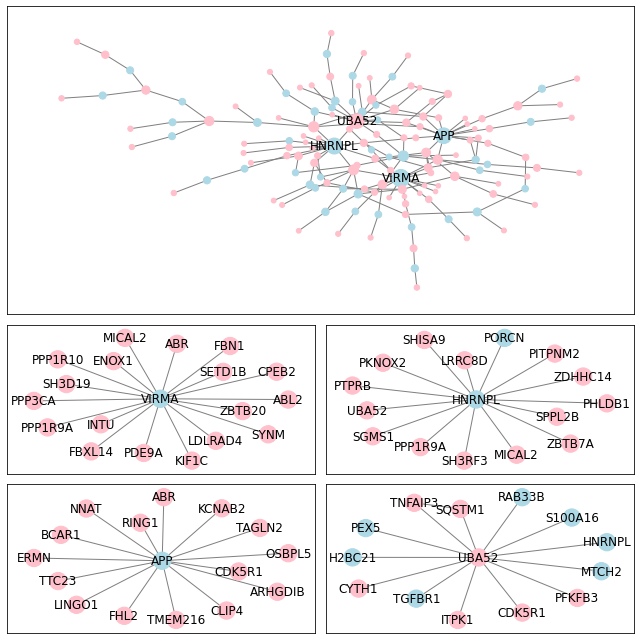

In [43]:
fig, axes = plt.subplot_mosaic([['A','A'],['A','A'],['B','C'],['D','E']], figsize=(9,9))
top_nodes = [pageranks[i][0] for i in range(4)]
node_labels = {node: node for node in top_nodes}
node_sizes = [pagerank_dict[node] * 7000 for node in submodule.nodes()]
node_colors = []
for node in submodule.nodes(data=True):
    if node[1]['isSeed']:
        node_colors.append('pink')
    else:
        node_colors.append('lightblue')
nx.draw_networkx(submodule,labels=node_labels,ax=axes['A'],node_color=node_colors,edge_color='grey',
                 node_size=node_sizes,pos=nx.kamada_kawai_layout(submodule))
plot_star(submodule, top_nodes[0], ax=axes['B'])
plot_star(submodule, top_nodes[1], ax=axes['C'])
plot_star(submodule, top_nodes[2], ax=axes['D'])
plot_star(submodule, top_nodes[3], ax=axes['E'])
fig.tight_layout()
fig.savefig('L4M_LCC_stars.pdf')

## Plot neighborhoods of top-ranked TFs.

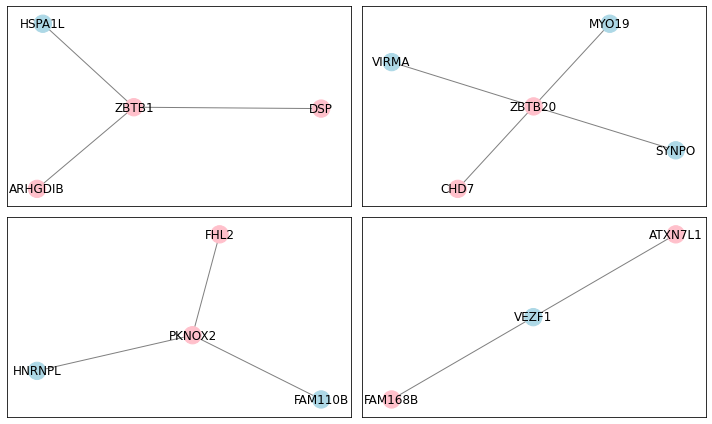

In [84]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
plot_star(submodule, ranked_tfs[0][1], ax=axes[0,0])
plot_star(submodule, ranked_tfs[1][1], ax=axes[0,1])
plot_star(submodule, ranked_tfs[2][1], ax=axes[1,0])
plot_star(submodule, ranked_tfs[3][1], ax=axes[1,1])
fig.tight_layout()
fig.savefig('L4M_stars_top_4_TFs.pdf')